https://www.kaggle.com/c/state-farm-distracted-driver-detection  

based on prev work by bmt.
Kaggle-dogs-cats-kernel/Kaggle-cats-dogs-redux-ensemble-1-load-data-model-predict.ipynb

In [1]:
sample_or_prod = False #True = sample, False = production
batch_size=32 # was 64, try small size due to out of memory error.

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [2]:
cat_desc = ['safe driving', 'texting - right', 'talking on the phone - right', 
            'texting - left', 'talking on the phone - left', 'operating the radio', 
            'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
print ("cat_desc:", type(cat_desc), len(cat_desc))

('cat_desc:', <type 'list'>, 10)


In [3]:
HOMEPATH = "/home/ubuntu/fastai/"
DATA_PATH = HOMEPATH + "data/state/"
print("HOMEPATH:", HOMEPATH)
print("DATA_PATH:", DATA_PATH)
import os
from __future__ import division, print_function


('HOMEPATH:', '/home/ubuntu/fastai/')
('DATA_PATH:', '/home/ubuntu/fastai/data/state/')


In [4]:
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile
import pandas as pd
import numpy as np
import random
import cv2
import gc

import matplotlib.image as mpimg


In [5]:
MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"
SCRAP_PATH = DATA_PATH+"scrap/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"

UNKNOWN = 'unknown/'


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)

WORKING_DATA: /home/ubuntu/fastai/data/state/
WORKING_TEST: /home/ubuntu/fastai/data/state/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/state/train/
WORKING_VALID: /home/ubuntu/fastai/data/state/valid/
s_or_p: _prod_


In [6]:
#check if dir exists, create if not already.
def makeNewDir(newDirPath):
    if not os.path.exists(newDirPath): 
        print("directory ", newDirPath, " did not exist, creating:")
        os.mkdir(newDirPath)
    else:
        print("directory ", newDirPath, "already existed. filecount = ", len(dirFileList(newDirPath)))


In [7]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]


In [8]:
#create scrap directory for temp copying of files.
makeNewDir(SCRAP_PATH)
makeNewDir(SCRAP_PATH+UNKNOWN)

directory  /home/ubuntu/fastai/data/state/scrap/ already existed. filecount =  0
directory  /home/ubuntu/fastai/data/state/scrap/unknown/ already existed. filecount =  0


In [9]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/state
.
├── models
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── c0
│   │   ├── c1
│   │   ├── c2
│   │   ├── c3
│   │   ├── c4
│   │   ├── c5
│   │   ├── c6
│   │   ├── c7
│   │   ├── c8
│   │   └── c9
│   └── valid
│       ├── c0
│       ├── c1
│       ├── c2
│       ├── c3
│       ├── c4
│       ├── c5
│       ├── c6
│       ├── c7
│       ├── c8
│       └── c9
├── scrap
│   └── unknown
├── test
│   └── unknown
├── train
│   ├── c0
│   ├── c1
│   ├── c2
│   ├── c3
│   ├── c4
│   ├── c5
│   ├── c6
│   ├── c7
│   ├── c8
│   └── c9
└── valid
    ├── c0
    ├── c1
    ├── c2
    ├── c3
    ├── c4
    ├── c5
    ├── c6
    ├── c7
    ├── c8
    └── c9

53 directories


In [10]:
CATEGORIES = []


for i in range(10):
    CATEGORIES.append("c"+str(i)+"/")
print ("CATEGORIES:", CATEGORIES)

CATEGORIES: ['c0/', 'c1/', 'c2/', 'c3/', 'c4/', 'c5/', 'c6/', 'c7/', 'c8/', 'c9/']


In [11]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)

In [12]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, ", len(weights)", len(layer.get_weights()), "\n")
        count +=1

In [13]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [14]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))
        
#NB: could have used global DATA_DIR_LIST  to access global variable DATA_DIR_LIST 
# without having to pass DATA_DIR_LIST as an arg, but this gives more flexability.

In [15]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/state/ 5
/home/ubuntu/fastai/data/state/models/ 15
/home/ubuntu/fastai/data/state/results/ 6
/home/ubuntu/fastai/data/state/sample/ 0
/home/ubuntu/fastai/data/state/sample/test/ 0
/home/ubuntu/fastai/data/state/sample/test/unknown/ 15945
/home/ubuntu/fastai/data/state/sample/train/ 0
/home/ubuntu/fastai/data/state/sample/train/c0/ 347
/home/ubuntu/fastai/data/state/sample/train/c1/ 314
/home/ubuntu/fastai/data/state/sample/train/c2/ 323
/home/ubuntu/fastai/data/state/sample/train/c3/ 325
/home/ubuntu/fastai/data/state/sample/train/c4/ 323
/home/ubuntu/fastai/data/state/sample/train/c5/ 322
/home/ubuntu/fastai/data/state/sample/train/c6/ 324
/home/ubuntu/fastai/data/state/sample/train/c7/ 278
/home/ubuntu/fastai/data/state/sample/train/c8/ 268
/home/ubuntu/fastai/data/state/sample/train/c9/ 298
/home/ubuntu/fastai/data/state/sample/valid/ 0
/home/ubuntu/fastai/data/state/sample/valid/c0/ 153
/home/ubuntu/fastai/data/state/sample/valid/c1/ 138
/home/ubuntu/fastai

In [16]:
os.chdir(HOMEPATH)
print ("current working directory:", os.getcwd())

%matplotlib inline
from __future__ import print_function, division
#path = "data/state/"
path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

current working directory: /home/ubuntu/fastai


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [17]:
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)#should be shuffle=True
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)
#test_batches = get_batches(WORKING_TEST, shuffle=False, batch_size=batch_size)
print (WORKING_TRAIN, type(trn_batches))
print (WORKING_VALID, type(val_batches))
#print (WORKING_TEST, type(test_batches))

#https://keras.io/preprocessing/image/
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#NB: utils.get_batches has default target_size=(224,224)

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
/home/ubuntu/fastai/data/state/train/ <class 'keras.preprocessing.image.DirectoryIterator'>
/home/ubuntu/fastai/data/state/valid/ <class 'keras.preprocessing.image.DirectoryIterator'>


In [18]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filename) = get_classes(WORKING_DATA)

print ("val_classes", type(val_classes), val_classes.shape)
print ("trn_classes", type(trn_classes), trn_classes.shape)
print ("val_labels", type(val_labels), val_labels.shape)
print ("trn_labels", type(trn_labels), trn_labels.shape)
print ("val_filenames", type(val_filenames), len(val_filenames))
print ("filenames", type(filenames), len(filenames))
print ("test_filename", type(test_filename), len(test_filename))
#nb: test_filename not used again until after model building, training and ensemble.

Found 15684 images belonging to 10 classes.
Found 6740 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.
val_classes <type 'numpy.ndarray'> (6740,)
trn_classes <type 'numpy.ndarray'> (15684,)
val_labels <type 'numpy.ndarray'> (6740, 10)
trn_labels <type 'numpy.ndarray'> (15684, 10)
val_filenames <type 'list'> 6740
filenames <type 'list'> 15684
test_filename <type 'list'> 79726


In [19]:
print ("test_filename[0]", test_filename[0])

test_filename[0] unknown/img_46339.jpg


In [20]:
print ("val_classes:", type(val_classes[0]), val_classes[0], np.unique(val_classes))
print ("trn_classes:", type(trn_classes[0]), trn_classes[0], np.unique(trn_classes))
print ("val_labels:", type(val_labels[0]), val_labels[0], np.unique(val_labels))
print ("trn_labels:", type(trn_labels[0]), trn_labels[0], np.unique(trn_labels))

val_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
trn_classes: <type 'numpy.int32'> 0 [0 1 2 3 4 5 6 7 8 9]
val_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]
trn_labels: <type 'numpy.ndarray'> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  1.]


In [35]:
model = Vgg16().model


In [36]:
#showLayersInfo(model)

In [37]:
conv_layers,fc_layers = split_at(model, Convolution2D)
#utils.split_at(model, layer_type) 
#splits model at last occurrance of layer_type. (in this case Convolution2D)


In [38]:
print ("model        # of layers:",  len(model.layers))
print ("conv_layers  # of layers:",  len(conv_layers))
print ("fc_layers    # of layers:",  len(fc_layers))

model        # of layers: 38
conv_layers  # of layers: 31
fc_layers    # of layers: 7


In [39]:
conv_model = Sequential(conv_layers)
#31 layers, all trainable, last layer = Convolution2D
#showLayersInfo(conv_model)

In [40]:
#showLayersInfo(Sequential(fc_layers))
#7 layers, all trainable, last layer = Dense, 1000 classes output.

In [41]:
startTime= datetime.now()
print ("startTime:", startTime)

#val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
#

val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print ("val_features:", val_features.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("trn_features:", trn_features.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: val_features and trn_features have shape (No of input images, 512, 14, 14)

#training:    Found 15684 images belonging to 10 classes. time = approx 3min.
#validation : Found 6740 images belonging to 10 classes.   time = approx 7min.

startTime: 2018-01-08 23:03:54.619851
val_features: (6740, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:02:44.449025
startTime: 2018-01-08 23:06:39.069102
trn_features: (15684, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:06:19.487367


In [42]:
#save_array(MODEL_PATH + 'train_convlayer_features.bc', trn_features)
#save_array(MODEL_PATH + 'valid_convlayer_features.bc', val_features)

In [43]:
#trn_features = load_array(MODEL_PATH+'train_convlayer_features.bc')
#val_features = load_array(MODEL_PATH+'valid_convlayer_features.bc')

In [44]:
startTime= datetime.now()
print ("startTime:", startTime)

trn = get_data(WORKING_TRAIN)
print ("trn:", trn.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
val = get_data(WORKING_VALID)
print ("val:", val.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#production mode:
# trn : takes approx 3m to run
# val : takes approx 1:20 to run

startTime: 2018-01-08 23:12:58.587571
Found 15684 images belonging to 10 classes.
trn: (15684, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:03:07.262277
startTime: 2018-01-08 23:16:05.850173
Found 6740 images belonging to 10 classes.
val: (6740, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:01:19.051404


In [45]:
#save_array(MODEL_PATH+'train_data.bc', trn)
#save_array(MODEL_PATH+'valid_data.bc', val)

In [46]:
#trn = load_array(MODEL_PATH+'train_data.bc')
#val = load_array(MODEL_PATH+'valid_data.bc')

In [47]:
showLayersInfo(model)

Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [48]:
print ("@start# of layers:", len(model.layers))#should be 38 layers before popping
model.pop()
model.pop()
print ("@end# of layers:", len(model.layers))#should be 36 layers after popping
#showLayersInfo(model)

@start# of layers: 38
@end# of layers: 36


In [49]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
____________________________________________________________________________________________________


In [50]:
showLayersInfo(model)

Number of layers :  36
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) , len(weights) 0 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (N

In [51]:
print ("trn_batches:", type(trn_batches), "trn_batches.nb_sample:", trn_batches.nb_sample)
print ("val_batches:", type(val_batches), "val_batches.nb_sample:", val_batches.nb_sample)

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'> trn_batches.nb_sample: 15684
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'> val_batches.nb_sample: 6740


In [52]:
startTime= datetime.now()
print ("startTime:", startTime)

ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
print ("ll_val_feat:", ll_val_feat.shape)
timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

startTime= datetime.now()
print ("startTime:", startTime)
ll_feat = model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("ll_feat:", ll_feat.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Returns : A Numpy array of predictions.
#NB: ll_val_feat & ll_feat has shape = (number of imaes, 4096)
#last layer of model is Dense with output: (None, 4096)
#NB: model = Vgg16().model then last two layers pop'd. 
#ie: not a standard VGG16 model and output needs fixing to predict classes

startTime: 2018-01-08 23:17:26.609801
ll_val_feat: (6740, 4096)
Time elapsed (hh:mm:ss.ms) 0:02:45.599212
startTime: 2018-01-08 23:20:12.209504
ll_feat: (15684, 4096)
Time elapsed (hh:mm:ss.ms) 0:06:22.436609


In [ ]:
#save_array(MODEL_PATH + 'train_ll_feat.bc', ll_feat)
#save_array(MODEL_PATH + 'valid_ll_feat.bc', ll_val_feat)

In [ ]:
#ll_feat = load_array(MODEL_PATH+ 'train_ll_feat.bc')
#ll_val_feat = load_array(MODEL_PATH + 'valid_ll_feat.bc')

In [24]:
def get_ll_layers():
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #NB: Dense needs to have 10 classes for this problem
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(10, activation='softmax') 
        ]

In [26]:
def train_last_layer(i):
    #nb: i is used in the filename to save weights.
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #set learning rate, train model, set learning rate again, train model.
    #pop last three layers from vgg16 model, make all layers non trainable.
    #add 3 layers created in get_ll_layers to end of model.
    #copy weights from 3 layers just trained to last three layers in vgg16 model.
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    #here the pretrained input from VGG16 is used as input to this model.
    #saves having to run the full VGG16 model, only running the layers created by get_ll_layers()
    history = ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    print ("train_last_layer:i:", i, ", ll_model.optimizer.lr:", ll_model.optimizer.lr )
    plot_history(history)
    
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    #nb: cannot show history with only one epoch.
    print ("ll_model.optimizer.lr:", ll_model.optimizer.lr)
    ll_model.save_weights(MODEL_PATH+'ll_bn' + s_or_p + i + '.h5')

    #create new vgg16 model & pop last 3 layers.
    vgg = Vgg16()
    model = vgg.model
    print("train_last_layer, model just created from Vgg16(), # layers = ", len(model.layers))
    model.pop(); model.pop(); model.pop()
    #
    for layer in model.layers: layer.trainable=False
    #set all layers to non trainable
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #create three layers ()
    ll_layers = get_ll_layers()
    
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense, add these layers to model.
    for layer in ll_layers: model.add(layer)
    
    #copy the weights from the above trained ll_model to the just added  last 3 layers in model.
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    
    #compile model so it is ready for use.
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(MODEL_PATH+'bn' + s_or_p + i + '.h5')
    print ("@ end of train_last_layer, # layers = ", len(model.layers))
    showLayersInfo(model)
    return model

In [27]:
def get_conv_model(model):
    #split model into 2 sets of layers. 
    #conv_layers = start up to & including the last Convolution2D
    #fc_layers   = rest of the model
    #returns model, list of layers, int position of last Convolution2D layer. 
    
    layers = model.layers
    
    #last_conv_idx = index of last Convolution2D layer
    last_conv_idx = [index for index,layer in enumerate(layers) 
                         if type(layer) is Convolution2D][-1]

    conv_layers = layers[:last_conv_idx+1]
    conv_model = Sequential(conv_layers)
    fc_layers = layers[last_conv_idx+1:]
    return conv_model, fc_layers, last_conv_idx

In [28]:
def get_fc_layers(p, in_shape):
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #previously dropped two layers to prevent model failing
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #NB: last layer = Dense - must have 10 classes to suit this problem
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        #BatchNormalization(),
        Dropout(p),
        #Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [ ]:
gc.collect()

In [ ]:
def train_dense_layers(i, model):
    #nb: i is used in the filename to save weights.
    
    print ("start: train_dense_layers: i:", i)
    print ("len(model.layers):", len(model.layers))
    #split model about last Convolutional2D layer
    conv_model, fc_layers, last_conv_idx = get_conv_model(model)
    #conv_model = Sqeuential(conv_layers) = list of layers, from start up to & including the last Convolution2D layer.
    #fc_layers   = rest of the model       
    
    #shape of last Convolution2D layer output.
    conv_shape = conv_model.output_shape[1:]
    
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense

    print ("train_dense_layers: showLayersInfo(fc_model):-----------START------------------------")
    showLayersInfo(fc_model)
    print ("train_dense_layers: showLayersInfo(Sequential(fc_layers)):-----------START-----------")
    showLayersInfo(Sequential(fc_layers))
    print ("-----------------------END-----------------------------------------------------------")
    print ("len(fc_model.layers):", len(fc_model.layers))#9 layers - as from def get_fc_layers
    print ("len(fc_layers):", len(fc_layers))            #7 layers - layers split from vgg16 after last Convolutional2D layer
    #copy weights from layers in fc_layers to the newly created fc_model. 
    count = 0
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        print ("count:", count)
        print("l1:", l1)
        print("l2:", l2)
        weights = l2.get_weights()
        print ("l1.get_weights():", len(l1.get_weights()))
        print ("l2.get_weights():", len(l2.get_weights()))
        l1.set_weights(weights)
        count += 1
    
    print ("marker AA")
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    history = fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
         batch_size=batch_size, validation_data=(val_features, val_labels))
    #was nb_epoch=2? increased since seeing good convergence here.
    #nb: accuracy is improving rapidly here. validation has much higher accuracy than training.
    plot_history(history)
    print ("marker BB")

    #setup data augmentation.
    gen = image.ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.05, 
                                   #width_zoom_range=0.05, #error - why???? redundant or not in this version of keras?
                                   zoom_range=0.05, 
                                   channel_shift_range=10, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   horizontal_flip=True)
    print ("marker CC")

    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    
    print ("marker DD")

    val_batches = image.ImageDataGenerator().flow(val, 
                                                  val_labels, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)
    
    
    print ("type(val_batches):", type(val_batches), "val_batches.n:", val_batches.n)

    print ("len(conv_model.layers):", len(conv_model.layers))#31 layers
    
    #set all layers in conv_model set to non trainable
    #for layer in conv_model.layers: 
    #    layer.trainable = False
    # made all layers trainable - since validation accuracy was exceeding training accuracy by a large margin.

    #print ("marker EE-all layers in conv_model set to non trainable")
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    #conv_shape ensures input shape from conv_model can be accepted.
    #add all layers to end of conv_model
    for layer in get_fc_layers(0.5, conv_shape): 
        conv_model.add(layer)
    #print ("showLayersInfo(conv_model): after 1. setting layers to non trainable & 2. adding get_fc_layers to conv_model")
    print ("showLayersInfo(conv_model): after adding get_fc_layers to conv_model")
    showLayersInfo(conv_model)
        
    
    #copy weights from fc_model.layers to the layers after last_conv_idx in conv_model.
    #nb: weights in fc_model were trained 
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())
    print ("marker FF-copied weights from fc_model.layers to the layers after last_conv_idx in conv_model.")
    
    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    conv_model.save_weights(MODEL_PATH+'no_dropout_bn' + s_or_p + i + '.h5')
    
    
    conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=1, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    
    #now make more of the models trainable. (this was in dogs/cats, needed to retrain models for different categories)
    #for layer in conv_model.layers[16:]: layer.trainable = True
    #for layer in conv_model.layers[8:]: layer.trainable = True

    print ("showLayersInfo(conv_model): after 1. copying weights to conv_model from fc_model.layers.")
    print ("2. fitting, setting layers 16: to trainable.")
    
    showLayersInfo(conv_model)


    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=8, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)
    #this was slow to improve. traing improves rapidly, validate accuracy does not, both are _VERY_ low <20%
    print ("history = conv_model.fit_generator(blah....), optimizer=Adam(1e-5)")
    plot_history(history)
    
    conv_model.optimizer.lr = 1e-7
    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.n, 
                             nb_epoch=10, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.n)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.save_weights(MODEL_PATH + s_or_p + 'aug' + i + '.h5')

In [ ]:
type(conv_model)

In [ ]:
num_emsembles = 1  #was 5, reduced to 1 to optimise training parameters.


#done run this block as previously ran this block and this notebook is solely for predicting using saved models.
#build the ensemble
#multiple model builds, model trainings. takes long time.
for i in range(num_emsembles):  
    i = str(i)
    print ("i:", i)
    model = train_last_layer(i)
    #a tthis point, model = vgg16 model, minus last three layers, plus layers BatchNormalization + Dropout + Dense
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #train_last_layer uses get_ll_layers to create 3 layer model, trains it, then pops last 3 layers from vgg16model
    #at end of train_last_layer model has 38 layers with last three layers being BatchNormalization + Dropout + Dense

    train_dense_layers(i, model)
    print ("run garbage collection.")
    gc.collect()
    print ("garbage collection completed.")
print ("completed.")

In [ ]:
#marker AA
#epoch 1/8 acc: 0.74 val_acc: 0.98 <1m per epoch with production data on p2.xlarge
#epoch 8/8 acc: 0.998 val_acc: 0.998 <1m per epoch with production data on p2.xlarge
#marker FF
#epoch 1/1           loss: 0.7727 - acc: 0.7531 - val_loss: 0.0101 - val_acc: 0.9975 10 minutes to run
#epoch 1/8 -  615s - loss: 0.3543 - acc: 0.8915 - val_loss: 0.0115 - val_acc: 0.9963
#Epoch 1/10 - 615s - loss: 0.0833 - acc: 0.9774 - val_loss: 0.0105 - val_acc: 0.9975
#

In [ ]:
for i in range(num_emsembles):
    print (MODEL_PATH + s_or_p + 'aug' + str(i) + '.h5')

Train on 15684 samples, validate on 6740 samples
Epoch 1/12
15684/15684 [==============================] - 2s - loss: 3.1259 - acc: 0.1229 - val_loss: 2.5653 - val_acc: 0.1518
Epoch 2/12
15684/15684 [==============================] - 2s - loss: 2.8156 - acc: 0.1641 - val_loss: 2.4083 - val_acc: 0.1958
Epoch 3/12
15684/15684 [==============================] - 2s - loss: 2.5958 - acc: 0.1984 - val_loss: 2.2709 - val_acc: 0.2445
Epoch 4/12
15684/15684 [==============================] - 2s - loss: 2.4274 - acc: 0.2374 - val_loss: 2.1687 - val_acc: 0.2820
Epoch 5/12
15684/15684 [==============================] - 2s - loss: 2.2956 - acc: 0.2771 - val_loss: 2.0942 - val_acc: 0.3105
Epoch 6/12
15684/15684 [==============================] - 2s - loss: 2.1739 - acc: 0.3022 - val_loss: 2.0339 - val_acc: 0.3326
Epoch 7/12
15684/15684 [==============================] - 2s - loss: 2.0775 - acc: 0.3337 - val_loss: 1.9857 - val_acc: 0.3533
Epoch 8/12
15684/15684 [==============================] - 2s -

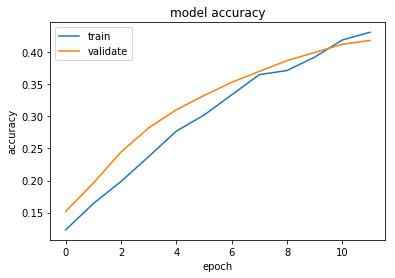

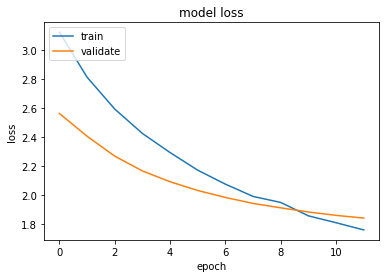

Train on 15684 samples, validate on 6740 samples
Epoch 1/1
15684/15684 [==============================] - 2s - loss: 1.7254 - acc: 0.4469 - val_loss: 1.8222 - val_acc: 0.4280
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) , len(weights) 0 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) , len(weights) 0 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) , len(weights) 2 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) , len(weights) 0 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 

In [54]:
ens_model2 = train_last_layer(str(11))
#just using this method to load the same stack of layers. ignore the accuracy returned.

In [ ]:
ens_model2.summary()

In [ ]:
for layer in ens_model2.layers: layer.trainable=True

In [ ]:
#START skip blocks of code not required for prediction

def get_ens_pred(arr, fname):
    ens_pred = []
    for i in range(num_emsembles):
        i = str(i)
        print ("loading weights file:", i)
        ens_model2.load_weights('{}{}{}.h5'.format(MODEL_PATH, fname, i))
        print ("predicting from weights file:", i)
        preds = ens_model2.predict(arr, batch_size=batch_size)
        ens_pred.append(preds)
        print ("len(ens_pred):", len(ens_pred), ", len(preds):", len(preds))
    return ens_pred

#recall: val = get_data(WORKING_VALID)
#val: (1500, 3, 224, 224)
startTime= datetime.now()
print ("startTime:", startTime)

val_pred2 = get_ens_pred(val, s_or_p + 'aug')

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


#nb: this loads weights from the files with 'aug' in filename. this is the final model build in method train_dense_layers

print ("len(val_pred2):", len(val_pred2))
print(val_pred2[0].shape)
print(val_pred2[0][0:10, :])

preds = val_pred2
preds = np.around(preds, decimals=1)
print (type(preds))
print (np.unique(preds))
preds[0][0:5,]


#calc categorical_accuracy for each prediction and for the average.
cat_acc = []
for i in range(num_emsembles):
    temp_val_preds = val_pred2[i]
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape)
    cat_acc.append(float(categorical_accuracy(val_labels, temp_val_preds).eval()))
    print ("i:", i, type(temp_val_preds), temp_val_preds.shape, ", categorical accuracy:", cat_acc[i])
print ("cat_acc:", type(cat_acc), cat_acc)


val_avg_preds2 = np.stack(val_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(val_avg_preds2):", type(val_avg_preds2), val_avg_preds2.shape)
print(val_avg_preds2[0:10, :])

print ("categorical accuracy from mean      :", float(categorical_accuracy(val_labels, val_avg_preds2).eval()))
print ("best individual categorical accuracy:", np.max(cat_acc))
#NB: mean accuracy is higher because it is choosing the best prediction row by row. then comparing with actual category.

In [ ]:
#end skip blocks of code not required for prediction

In [ ]:
len(test_filename)

#hold using this block: causes crash.
startTime= datetime.now()
print ("startTime:", startTime)

test = get_data(WORKING_TEST)
print ("test:", test.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
print ("test:", type(test), test.shape)

In [ ]:
test_filename[len(test_filename)-1]

In [32]:
def emptyDir(directory):
    for the_file in os.listdir(directory):
        file_path = os.path.join(directory, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path) #uncomment to remove one level of sub-dir
        except Exception as e:
            print(e)

In [ ]:
#create list of filenames with the unknown/ dropped
filenames = []
for i in range(len(test_filename)):
    filenames.append(test_filename[i][8:])
    #print (filenames[i])
print (filenames[0:5])

In [ ]:
len(filenames)

In [ ]:
#SCRAP_PATH+UNKNOWN
print ("SCRAP_PATH+UNKNOWN:", SCRAP_PATH+UNKNOWN)
emptyDir(SCRAP_PATH+UNKNOWN)
results = np.empty(shape=(0,10)) 
step_size = 5000
startTime= datetime.now()
print ("startTime:", startTime)
count = 0
num_runs = len(filenames)/step_size

for i in range(0, len(filenames), step_size):
    #print (i, range(i, min(len(filenames),i+step_size)))
    #copy files in this list to SCRAP_PATH+UNKNOWN
    for j in range(i, min(len(filenames),i+step_size)):
        copyfile(WORKING_TEST+UNKNOWN+filenames[j], SCRAP_PATH+UNKNOWN+filenames[j])
    scrap_data = get_data(SCRAP_PATH)
    scrap_preds = ens_model2.predict(scrap_data, batch_size=batch_size)
    #print ("scrap_preds:", type(scrap_preds), scrap_preds.shape)
    results = np.vstack((results,scrap_preds))
    emptyDir(SCRAP_PATH+UNKNOWN)
    print ("results:", type(results), results.shape)
    timeElapsed=datetime.now()-startTime
    print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
    print ("count:", count, " of ", num_runs)
    count += 1
    #break

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
print("finished.")
#zzz

In [ ]:
results.shape

#find and remove row for 'face.png'
#should not need this later as 'face.png' now written to another dir.
filenames.index("face.png")
#should throw error if face.png not in list.

results[filenames.index("face.png"),]

temp = results
temp = np.delete(temp, filenames.index("face.png"), axis=0)
temp.shape

#now delete "face.png" from filenames
print ("len(filenames):", len(filenames))
filenames.remove('face.png')
print ("len(filenames):", len(filenames))

In [ ]:
#save results (numpy.ndarray) to file.
#
np.save(RESULTS_PATH+"results_7jan2017.csv", results)


In [ ]:
test_reload = np.load(RESULTS_PATH+"results_7jan2017.csv.npy")
print (type(test_reload), test_reload.shape)
test_reload[0:2,]

os.chdir(SCRAP_PATH)
print (os.getcwd())  
from scipy import misc  
f = misc.face()  
misc.imsave('face.png', f)  
import matplotlib.pyplot as plt  
plt.imshow(f)  
plt.show()  
print ("f:", f.shape, f.dtype)  
face = misc.imread('face.png')  
print ("face:", face.shape, face.dtype)  

#recall: test = get_data(WORKING_TEST)
#<type 'numpy.ndarray'> (2500, 3, 224, 224)
startTime= datetime.now()
print ("startTime:", startTime)

#test_pred2 = get_ens_pred(test, s_or_p + 'aug')
#preds = ens_model2.predict(arr, batch_size=batch_size)


timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


#print ("test_pred2.shape:", test_pred2.shape)
#approx time to run : production version: 

print ("len(val_pred2):", len(test_pred2))
print(test_pred2[0].shape)


print(test_pred2[0][0:10, :])

avg_test_pred2 = np.stack(test_pred2).mean(axis=0)
#get the mean prediction across all 
print ("type(avg_test_pred2):", type(avg_test_pred2), avg_test_pred2.shape)
print(avg_test_pred2[0:10, :])

In [ ]:
#NB: need to check last few block suit 10 category predictions and output format required for kaggle submisison.

In [ ]:

#preds_submit = np.around(avg_test_pred2, decimals=1)
#preds_submit = np.around(test_pred2, decimals=1)
#preds_submit = np.around(results, decimals=1)

preds_submit = np.around(temp, decimals=1)


preds_submit[0:5,]

In [ ]:
filenames_array = np.reshape(np.array(filenames), (len(filenames),1))
filenames_array.shape

In [ ]:
preds_submit.shape

In [ ]:
results2 = pd.concat([pd.DataFrame(filenames),pd.DataFrame(preds_submit)],axis=1)

In [ ]:
results2.shape

In [ ]:
CATEGORIES
categories_ = []
for categ in CATEGORIES:
    #print (categ[0:2])
    categories_.append(categ[0:2])
categories_

In [ ]:
results2.columns = ['img']+categories_

In [ ]:
list(results2)

In [ ]:
results2.head()

In [ ]:
#add column to results2 composed of the integers from the filename. 
#sort results2 by this column in ascending order
#drop this new column

results2.sort_values(['img'], ascending=[1], inplace=True)
results2.head(5)

In [ ]:
WORKING_TEST+UNKNOWN+filenames[0]

In [ ]:
#method to plot image and row of predictions, column number of highest probability and description of that column.
def file_categ_predict(df_results, filename):
    print ("filename:", filename)
    img=mpimg.imread(filename)
    imgplot = plt.imshow(img)
    #find row in results2 with corresponding filename.
    tempdf = df_results.loc[results2['img'] == filename]
    print (tempdf)
    tempdf = tempdf.drop(['img'], axis=1)
    tempList = list(tempdf)
    categ_index = np.argmax(tempList)
    categ = cat_desc[categ_index]
    print ("max prob:", tempList[categ_index], ", at column ", categ_index, ", category:", categ)
    
    

In [ ]:
file_categ_predict(results2, WORKING_TEST+UNKNOWN + filenames[3])

In [ ]:
cat_desc

In [ ]:
RESULTS_PATH

In [ ]:
%cd $RESULTS_PATH
submission_file_name = "ensemble_submit"+ s_or_p +".csv"
results2.to_csv(submission_file_name, index=False, float_format='%.1f')
print ("written to :", submission_file_name)

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread(WORKING_TEST+UNKNOWN + filenames[1])
imgplot = plt.imshow(img)
print (results2.head(1))
cat_desc[7]

kg submit  ensemble_submit_sample_.csv -u user-email -p password -c state-farm-distracted-driver-detection

In [ ]:
cat_desc

In [ ]:
#Submission : must have 79726 rows

In [30]:
#create list of filenames with the unknown/ dropped
valid_filenames = []
for i in range(len(val_filenames)):
    valid_filenames.append(val_filenames[i][3:])
    #print (filenames[i])
print (valid_filenames[0:5])
print (val_filenames[0:5])

['img_24009.jpg', 'img_71538.jpg', 'img_92725.jpg', 'img_39356.jpg', 'img_71499.jpg']
['c0/img_24009.jpg', 'c0/img_71538.jpg', 'c0/img_92725.jpg', 'c0/img_39356.jpg', 'c0/img_71499.jpg']


In [55]:
#SCRAP_PATH+UNKNOWN
print ("SCRAP_PATH+UNKNOWN:", SCRAP_PATH+UNKNOWN)
emptyDir(SCRAP_PATH+UNKNOWN)
valid_results = np.empty(shape=(0,10)) 
step_size = 5000
startTime= datetime.now()
print ("startTime:", startTime)
count = 0
num_runs = len(valid_filenames)/step_size

for i in range(0, len(valid_filenames), step_size):
    #print (i, range(i, min(len(filenames),i+step_size)))
    #copy files in this list to SCRAP_PATH+UNKNOWN
    for j in range(i, min(len(valid_filenames),i+step_size)):
        copyfile(WORKING_VALID+val_filenames[j], SCRAP_PATH+UNKNOWN+valid_filenames[j])
    #nb: copy files from c0/ c1/ c2 etc to unknown/
    scrap_data = get_data(SCRAP_PATH)
    scrap_preds = ens_model2.predict(scrap_data, batch_size=batch_size)
    #print ("scrap_preds:", type(scrap_preds), scrap_preds.shape)
    valid_results = np.vstack((valid_results,scrap_preds))
    emptyDir(SCRAP_PATH+UNKNOWN)
    print ("valid_results:", type(valid_results), valid_results.shape)
    timeElapsed=datetime.now()-startTime
    print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
    print ("count:", count, " of ", num_runs)
    count += 1
    #break

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
print("finished.")
#zzz

SCRAP_PATH+UNKNOWN: /home/ubuntu/fastai/data/state/scrap/unknown/
startTime: 2018-01-08 23:37:15.874919
Found 5000 images belonging to 1 classes.
valid_results: <type 'numpy.ndarray'> (5000, 10)
Time elapsed (hh:mm:ss.ms) 0:03:03.602931
count: 0  of  1.348
Found 1740 images belonging to 1 classes.
valid_results: <type 'numpy.ndarray'> (6740, 10)
Time elapsed (hh:mm:ss.ms) 0:04:06.319963
count: 1  of  1.348
Time elapsed (hh:mm:ss.ms) 0:04:06.321162
finished.


In [56]:
valid_results[0:3,]

array([[  4.8795e-24,   8.5058e-38,   1.7542e-17,   9.9981e-01,   8.4176e-40,   8.6689e-33,
          6.0816e-43,   1.9040e-04,   3.5329e-30,   2.7708e-12],
       [  0.0000e+00,   0.0000e+00,   9.8513e-35,   1.0522e-34,   1.4657e-35,   6.9742e-23,
          0.0000e+00,   2.7920e-32,   1.0000e+00,   1.1634e-36],
       [  1.7838e-39,   0.0000e+00,   0.0000e+00,   2.1529e-27,   8.8761e-39,   0.0000e+00,
          0.0000e+00,   0.0000e+00,   0.0000e+00,   1.0000e+00]])

In [69]:
#compare valid_results predicted)
err_count = 0
for j in range(len(valid_filenames)):
    #print (valid_results[j,])
    categ_index = np.argmax(list(valid_results[j,]))
    categ = cat_desc[categ_index]
    actual_class = int(val_filenames[j][1:2])
    if actual_class != categ_index:
        err_count += 1
    print (j, ":", val_filenames[j], "actual class:", actual_class, "predicted class:", categ_index, categ)
    #print (int(val_filenames[j][1:2]))
    #break
print ("err_count:", err_count, "len(valid_filenames:", len(valid_filenames), 1-err_count/len(valid_filenames))

0 : c0/img_24009.jpg actual class: 0 predicted class: 3 texting - left
1 : c0/img_71538.jpg actual class: 0 predicted class: 8 hair and makeup
2 : c0/img_92725.jpg actual class: 0 predicted class: 9 talking to passenger
3 : c0/img_39356.jpg actual class: 0 predicted class: 9 talking to passenger
4 : c0/img_71499.jpg actual class: 0 predicted class: 3 texting - left
5 : c0/img_10662.jpg actual class: 0 predicted class: 9 talking to passenger
6 : c0/img_39682.jpg actual class: 0 predicted class: 3 texting - left
7 : c0/img_74351.jpg actual class: 0 predicted class: 7 reaching behind
8 : c0/img_4854.jpg actual class: 0 predicted class: 9 talking to passenger
9 : c0/img_70220.jpg actual class: 0 predicted class: 9 talking to passenger
10 : c0/img_30400.jpg actual class: 0 predicted class: 3 texting - left
11 : c0/img_99640.jpg actual class: 0 predicted class: 7 reaching behind
12 : c0/img_15934.jpg actual class: 0 predicted class: 7 reaching behind
13 : c0/img_44388.jpg actual class: 0 pre

258 : c0/img_17359.jpg actual class: 0 predicted class: 8 hair and makeup
259 : c0/img_90273.jpg actual class: 0 predicted class: 3 texting - left
260 : c0/img_101702.jpg actual class: 0 predicted class: 9 talking to passenger
261 : c0/img_7990.jpg actual class: 0 predicted class: 7 reaching behind
262 : c0/img_28115.jpg actual class: 0 predicted class: 8 hair and makeup
263 : c0/img_24692.jpg actual class: 0 predicted class: 9 talking to passenger
264 : c0/img_63152.jpg actual class: 0 predicted class: 9 talking to passenger
265 : c0/img_61568.jpg actual class: 0 predicted class: 8 hair and makeup
266 : c0/img_66709.jpg actual class: 0 predicted class: 9 talking to passenger
267 : c0/img_14705.jpg actual class: 0 predicted class: 5 operating the radio
268 : c0/img_55719.jpg actual class: 0 predicted class: 9 talking to passenger
269 : c0/img_10609.jpg actual class: 0 predicted class: 9 talking to passenger
270 : c0/img_75225.jpg actual class: 0 predicted class: 2 talking on the phone 

477 : c0/img_1063.jpg actual class: 0 predicted class: 9 talking to passenger
478 : c0/img_1928.jpg actual class: 0 predicted class: 3 texting - left
479 : c0/img_37676.jpg actual class: 0 predicted class: 8 hair and makeup
480 : c0/img_30245.jpg actual class: 0 predicted class: 9 talking to passenger
481 : c0/img_63126.jpg actual class: 0 predicted class: 9 talking to passenger
482 : c0/img_7828.jpg actual class: 0 predicted class: 7 reaching behind
483 : c0/img_77140.jpg actual class: 0 predicted class: 9 talking to passenger
484 : c0/img_58686.jpg actual class: 0 predicted class: 2 talking on the phone - right
485 : c0/img_19401.jpg actual class: 0 predicted class: 7 reaching behind
486 : c0/img_78110.jpg actual class: 0 predicted class: 3 texting - left
487 : c0/img_71078.jpg actual class: 0 predicted class: 9 talking to passenger
488 : c0/img_23874.jpg actual class: 0 predicted class: 8 hair and makeup
489 : c0/img_21731.jpg actual class: 0 predicted class: 9 talking to passenger


685 : c0/img_87846.jpg actual class: 0 predicted class: 4 talking on the phone - left
686 : c0/img_63634.jpg actual class: 0 predicted class: 8 hair and makeup
687 : c0/img_50920.jpg actual class: 0 predicted class: 7 reaching behind
688 : c0/img_24289.jpg actual class: 0 predicted class: 3 texting - left
689 : c0/img_55312.jpg actual class: 0 predicted class: 7 reaching behind
690 : c0/img_73468.jpg actual class: 0 predicted class: 3 texting - left
691 : c0/img_56773.jpg actual class: 0 predicted class: 7 reaching behind
692 : c0/img_96159.jpg actual class: 0 predicted class: 8 hair and makeup
693 : c0/img_24317.jpg actual class: 0 predicted class: 9 talking to passenger
694 : c0/img_32813.jpg actual class: 0 predicted class: 3 texting - left
695 : c0/img_75458.jpg actual class: 0 predicted class: 7 reaching behind
696 : c0/img_85555.jpg actual class: 0 predicted class: 2 talking on the phone - right
697 : c0/img_78051.jpg actual class: 0 predicted class: 7 reaching behind
698 : c0/im

879 : c1/img_78090.jpg actual class: 1 predicted class: 9 talking to passenger
880 : c1/img_4330.jpg actual class: 1 predicted class: 8 hair and makeup
881 : c1/img_77658.jpg actual class: 1 predicted class: 9 talking to passenger
882 : c1/img_7152.jpg actual class: 1 predicted class: 9 talking to passenger
883 : c1/img_2212.jpg actual class: 1 predicted class: 3 texting - left
884 : c1/img_60435.jpg actual class: 1 predicted class: 8 hair and makeup
885 : c1/img_60251.jpg actual class: 1 predicted class: 8 hair and makeup
886 : c1/img_97168.jpg actual class: 1 predicted class: 9 talking to passenger
887 : c1/img_21080.jpg actual class: 1 predicted class: 7 reaching behind
888 : c1/img_40608.jpg actual class: 1 predicted class: 3 texting - left
889 : c1/img_38125.jpg actual class: 1 predicted class: 3 texting - left
890 : c1/img_10247.jpg actual class: 1 predicted class: 7 reaching behind
891 : c1/img_14936.jpg actual class: 1 predicted class: 7 reaching behind
892 : c1/img_35980.jpg a

1117 : c1/img_23109.jpg actual class: 1 predicted class: 9 talking to passenger
1118 : c1/img_75027.jpg actual class: 1 predicted class: 0 safe driving
1119 : c1/img_5680.jpg actual class: 1 predicted class: 9 talking to passenger
1120 : c1/img_33997.jpg actual class: 1 predicted class: 8 hair and makeup
1121 : c1/img_3099.jpg actual class: 1 predicted class: 9 talking to passenger
1122 : c1/img_30504.jpg actual class: 1 predicted class: 7 reaching behind
1123 : c1/img_75390.jpg actual class: 1 predicted class: 9 talking to passenger
1124 : c1/img_8663.jpg actual class: 1 predicted class: 9 talking to passenger
1125 : c1/img_84832.jpg actual class: 1 predicted class: 9 talking to passenger
1126 : c1/img_78552.jpg actual class: 1 predicted class: 5 operating the radio
1127 : c1/img_32341.jpg actual class: 1 predicted class: 8 hair and makeup
1128 : c1/img_6039.jpg actual class: 1 predicted class: 7 reaching behind
1129 : c1/img_4343.jpg actual class: 1 predicted class: 0 safe driving
11

1310 : c1/img_4446.jpg actual class: 1 predicted class: 7 reaching behind
1311 : c1/img_93557.jpg actual class: 1 predicted class: 9 talking to passenger
1312 : c1/img_75260.jpg actual class: 1 predicted class: 0 safe driving
1313 : c1/img_59189.jpg actual class: 1 predicted class: 0 safe driving
1314 : c1/img_7680.jpg actual class: 1 predicted class: 8 hair and makeup
1315 : c1/img_5145.jpg actual class: 1 predicted class: 8 hair and makeup
1316 : c1/img_64821.jpg actual class: 1 predicted class: 9 talking to passenger
1317 : c1/img_11288.jpg actual class: 1 predicted class: 0 safe driving
1318 : c1/img_62226.jpg actual class: 1 predicted class: 9 talking to passenger
1319 : c1/img_5242.jpg actual class: 1 predicted class: 7 reaching behind
1320 : c1/img_62475.jpg actual class: 1 predicted class: 7 reaching behind
1321 : c1/img_22597.jpg actual class: 1 predicted class: 9 talking to passenger
1322 : c1/img_76848.jpg actual class: 1 predicted class: 5 operating the radio
1323 : c1/img_

1494 : c2/img_36811.jpg actual class: 2 predicted class: 8 hair and makeup
1495 : c2/img_2147.jpg actual class: 2 predicted class: 9 talking to passenger
1496 : c2/img_48035.jpg actual class: 2 predicted class: 3 texting - left
1497 : c2/img_28012.jpg actual class: 2 predicted class: 8 hair and makeup
1498 : c2/img_19343.jpg actual class: 2 predicted class: 7 reaching behind
1499 : c2/img_40897.jpg actual class: 2 predicted class: 8 hair and makeup
1500 : c2/img_81235.jpg actual class: 2 predicted class: 2 talking on the phone - right
1501 : c2/img_42555.jpg actual class: 2 predicted class: 9 talking to passenger
1502 : c2/img_12784.jpg actual class: 2 predicted class: 8 hair and makeup
1503 : c2/img_35196.jpg actual class: 2 predicted class: 7 reaching behind
1504 : c2/img_6071.jpg actual class: 2 predicted class: 3 texting - left
1505 : c2/img_14040.jpg actual class: 2 predicted class: 8 hair and makeup
1506 : c2/img_93382.jpg actual class: 2 predicted class: 3 texting - left
1507 : 

1678 : c2/img_44567.jpg actual class: 2 predicted class: 9 talking to passenger
1679 : c2/img_31930.jpg actual class: 2 predicted class: 3 texting - left
1680 : c2/img_9070.jpg actual class: 2 predicted class: 9 talking to passenger
1681 : c2/img_91561.jpg actual class: 2 predicted class: 9 talking to passenger
1682 : c2/img_50063.jpg actual class: 2 predicted class: 3 texting - left
1683 : c2/img_68798.jpg actual class: 2 predicted class: 8 hair and makeup
1684 : c2/img_97380.jpg actual class: 2 predicted class: 9 talking to passenger
1685 : c2/img_85600.jpg actual class: 2 predicted class: 9 talking to passenger
1686 : c2/img_5786.jpg actual class: 2 predicted class: 9 talking to passenger
1687 : c2/img_66370.jpg actual class: 2 predicted class: 9 talking to passenger
1688 : c2/img_74616.jpg actual class: 2 predicted class: 9 talking to passenger
1689 : c2/img_4913.jpg actual class: 2 predicted class: 9 talking to passenger
1690 : c2/img_13764.jpg actual class: 2 predicted class: 9 t

1822 : c2/img_33461.jpg actual class: 2 predicted class: 7 reaching behind
1823 : c2/img_31097.jpg actual class: 2 predicted class: 9 talking to passenger
1824 : c2/img_17049.jpg actual class: 2 predicted class: 8 hair and makeup
1825 : c2/img_100646.jpg actual class: 2 predicted class: 9 talking to passenger
1826 : c2/img_31572.jpg actual class: 2 predicted class: 7 reaching behind
1827 : c2/img_55939.jpg actual class: 2 predicted class: 9 talking to passenger
1828 : c2/img_5018.jpg actual class: 2 predicted class: 8 hair and makeup
1829 : c2/img_27627.jpg actual class: 2 predicted class: 2 talking on the phone - right
1830 : c2/img_48228.jpg actual class: 2 predicted class: 7 reaching behind
1831 : c2/img_17703.jpg actual class: 2 predicted class: 9 talking to passenger
1832 : c2/img_14731.jpg actual class: 2 predicted class: 3 texting - left
1833 : c2/img_94307.jpg actual class: 2 predicted class: 3 texting - left
1834 : c2/img_29065.jpg actual class: 2 predicted class: 9 talking to

2055 : c2/img_23792.jpg actual class: 2 predicted class: 3 texting - left
2056 : c2/img_78324.jpg actual class: 2 predicted class: 0 safe driving
2057 : c2/img_66670.jpg actual class: 2 predicted class: 3 texting - left
2058 : c2/img_36108.jpg actual class: 2 predicted class: 8 hair and makeup
2059 : c2/img_59696.jpg actual class: 2 predicted class: 8 hair and makeup
2060 : c2/img_70227.jpg actual class: 2 predicted class: 7 reaching behind
2061 : c2/img_82245.jpg actual class: 2 predicted class: 9 talking to passenger
2062 : c2/img_15074.jpg actual class: 2 predicted class: 3 texting - left
2063 : c2/img_97487.jpg actual class: 2 predicted class: 8 hair and makeup
2064 : c2/img_81706.jpg actual class: 2 predicted class: 8 hair and makeup
2065 : c2/img_8138.jpg actual class: 2 predicted class: 8 hair and makeup
2066 : c2/img_71104.jpg actual class: 2 predicted class: 7 reaching behind
2067 : c2/img_20463.jpg actual class: 2 predicted class: 3 texting - left
2068 : c2/img_31145.jpg actu

2244 : c3/img_51310.jpg actual class: 3 predicted class: 9 talking to passenger
2245 : c3/img_25445.jpg actual class: 3 predicted class: 8 hair and makeup
2246 : c3/img_21240.jpg actual class: 3 predicted class: 9 talking to passenger
2247 : c3/img_96949.jpg actual class: 3 predicted class: 9 talking to passenger
2248 : c3/img_72107.jpg actual class: 3 predicted class: 9 talking to passenger
2249 : c3/img_17998.jpg actual class: 3 predicted class: 7 reaching behind
2250 : c3/img_5780.jpg actual class: 3 predicted class: 9 talking to passenger
2251 : c3/img_82742.jpg actual class: 3 predicted class: 7 reaching behind
2252 : c3/img_52843.jpg actual class: 3 predicted class: 8 hair and makeup
2253 : c3/img_61727.jpg actual class: 3 predicted class: 0 safe driving
2254 : c3/img_68558.jpg actual class: 3 predicted class: 0 safe driving
2255 : c3/img_5295.jpg actual class: 3 predicted class: 9 talking to passenger
2256 : c3/img_99947.jpg actual class: 3 predicted class: 8 hair and makeup
225

2553 : c3/img_91094.jpg actual class: 3 predicted class: 9 talking to passenger
2554 : c3/img_33170.jpg actual class: 3 predicted class: 3 texting - left
2555 : c3/img_39145.jpg actual class: 3 predicted class: 8 hair and makeup
2556 : c3/img_65524.jpg actual class: 3 predicted class: 8 hair and makeup
2557 : c3/img_15032.jpg actual class: 3 predicted class: 9 talking to passenger
2558 : c3/img_56292.jpg actual class: 3 predicted class: 7 reaching behind
2559 : c3/img_21286.jpg actual class: 3 predicted class: 8 hair and makeup
2560 : c3/img_88084.jpg actual class: 3 predicted class: 3 texting - left
2561 : c3/img_74659.jpg actual class: 3 predicted class: 7 reaching behind
2562 : c3/img_12185.jpg actual class: 3 predicted class: 9 talking to passenger
2563 : c3/img_48914.jpg actual class: 3 predicted class: 7 reaching behind
2564 : c3/img_39355.jpg actual class: 3 predicted class: 8 hair and makeup
2565 : c3/img_37427.jpg actual class: 3 predicted class: 7 reaching behind
2566 : c3/im

2791 : c3/img_6220.jpg actual class: 3 predicted class: 2 talking on the phone - right
2792 : c3/img_4287.jpg actual class: 3 predicted class: 9 talking to passenger
2793 : c3/img_14564.jpg actual class: 3 predicted class: 9 talking to passenger
2794 : c3/img_19908.jpg actual class: 3 predicted class: 9 talking to passenger
2795 : c3/img_87934.jpg actual class: 3 predicted class: 3 texting - left
2796 : c3/img_38244.jpg actual class: 3 predicted class: 7 reaching behind
2797 : c3/img_85118.jpg actual class: 3 predicted class: 2 talking on the phone - right
2798 : c3/img_19771.jpg actual class: 3 predicted class: 9 talking to passenger
2799 : c3/img_40181.jpg actual class: 3 predicted class: 8 hair and makeup
2800 : c3/img_27169.jpg actual class: 3 predicted class: 7 reaching behind
2801 : c3/img_63556.jpg actual class: 3 predicted class: 8 hair and makeup
2802 : c3/img_40917.jpg actual class: 3 predicted class: 7 reaching behind
2803 : c3/img_34546.jpg actual class: 3 predicted class: 

3024 : c4/img_51696.jpg actual class: 4 predicted class: 0 safe driving
3025 : c4/img_9310.jpg actual class: 4 predicted class: 8 hair and makeup
3026 : c4/img_56370.jpg actual class: 4 predicted class: 8 hair and makeup
3027 : c4/img_46527.jpg actual class: 4 predicted class: 8 hair and makeup
3028 : c4/img_27527.jpg actual class: 4 predicted class: 8 hair and makeup
3029 : c4/img_6108.jpg actual class: 4 predicted class: 3 texting - left
3030 : c4/img_80197.jpg actual class: 4 predicted class: 3 texting - left
3031 : c4/img_58244.jpg actual class: 4 predicted class: 7 reaching behind
3032 : c4/img_66056.jpg actual class: 4 predicted class: 7 reaching behind
3033 : c4/img_73497.jpg actual class: 4 predicted class: 8 hair and makeup
3034 : c4/img_28423.jpg actual class: 4 predicted class: 3 texting - left
3035 : c4/img_17118.jpg actual class: 4 predicted class: 9 talking to passenger
3036 : c4/img_79859.jpg actual class: 4 predicted class: 3 texting - left
3037 : c4/img_96567.jpg actua

3258 : c4/img_22476.jpg actual class: 4 predicted class: 8 hair and makeup
3259 : c4/img_61548.jpg actual class: 4 predicted class: 3 texting - left
3260 : c4/img_27100.jpg actual class: 4 predicted class: 3 texting - left
3261 : c4/img_99325.jpg actual class: 4 predicted class: 8 hair and makeup
3262 : c4/img_79551.jpg actual class: 4 predicted class: 9 talking to passenger
3263 : c4/img_14873.jpg actual class: 4 predicted class: 0 safe driving
3264 : c4/img_91845.jpg actual class: 4 predicted class: 8 hair and makeup
3265 : c4/img_47057.jpg actual class: 4 predicted class: 9 talking to passenger
3266 : c4/img_34611.jpg actual class: 4 predicted class: 9 talking to passenger
3267 : c4/img_7629.jpg actual class: 4 predicted class: 7 reaching behind
3268 : c4/img_36298.jpg actual class: 4 predicted class: 9 talking to passenger
3269 : c4/img_87175.jpg actual class: 4 predicted class: 3 texting - left
3270 : c4/img_48663.jpg actual class: 4 predicted class: 9 talking to passenger
3271 : 

3504 : c4/img_27597.jpg actual class: 4 predicted class: 3 texting - left
3505 : c4/img_92019.jpg actual class: 4 predicted class: 8 hair and makeup
3506 : c4/img_14593.jpg actual class: 4 predicted class: 8 hair and makeup
3507 : c4/img_56611.jpg actual class: 4 predicted class: 5 operating the radio
3508 : c4/img_37258.jpg actual class: 4 predicted class: 9 talking to passenger
3509 : c4/img_60938.jpg actual class: 4 predicted class: 9 talking to passenger
3510 : c4/img_79824.jpg actual class: 4 predicted class: 8 hair and makeup
3511 : c4/img_70764.jpg actual class: 4 predicted class: 8 hair and makeup
3512 : c4/img_81594.jpg actual class: 4 predicted class: 9 talking to passenger
3513 : c4/img_2413.jpg actual class: 4 predicted class: 8 hair and makeup
3514 : c4/img_94425.jpg actual class: 4 predicted class: 3 texting - left
3515 : c4/img_73704.jpg actual class: 4 predicted class: 9 talking to passenger
3516 : c4/img_4777.jpg actual class: 4 predicted class: 8 hair and makeup
3517 

3753 : c5/img_6976.jpg actual class: 5 predicted class: 9 talking to passenger
3754 : c5/img_75798.jpg actual class: 5 predicted class: 8 hair and makeup
3755 : c5/img_46433.jpg actual class: 5 predicted class: 9 talking to passenger
3756 : c5/img_10318.jpg actual class: 5 predicted class: 9 talking to passenger
3757 : c5/img_33419.jpg actual class: 5 predicted class: 7 reaching behind
3758 : c5/img_43895.jpg actual class: 5 predicted class: 3 texting - left
3759 : c5/img_42793.jpg actual class: 5 predicted class: 9 talking to passenger
3760 : c5/img_18028.jpg actual class: 5 predicted class: 7 reaching behind
3761 : c5/img_99001.jpg actual class: 5 predicted class: 5 operating the radio
3762 : c5/img_7390.jpg actual class: 5 predicted class: 9 talking to passenger
3763 : c5/img_44367.jpg actual class: 5 predicted class: 9 talking to passenger
3764 : c5/img_65224.jpg actual class: 5 predicted class: 8 hair and makeup
3765 : c5/img_42196.jpg actual class: 5 predicted class: 8 hair and m

4002 : c5/img_90838.jpg actual class: 5 predicted class: 9 talking to passenger
4003 : c5/img_87356.jpg actual class: 5 predicted class: 9 talking to passenger
4004 : c5/img_43900.jpg actual class: 5 predicted class: 8 hair and makeup
4005 : c5/img_44796.jpg actual class: 5 predicted class: 8 hair and makeup
4006 : c5/img_44591.jpg actual class: 5 predicted class: 8 hair and makeup
4007 : c5/img_51182.jpg actual class: 5 predicted class: 7 reaching behind
4008 : c5/img_2772.jpg actual class: 5 predicted class: 9 talking to passenger
4009 : c5/img_52288.jpg actual class: 5 predicted class: 3 texting - left
4010 : c5/img_69478.jpg actual class: 5 predicted class: 8 hair and makeup
4011 : c5/img_30013.jpg actual class: 5 predicted class: 9 talking to passenger
4012 : c5/img_6092.jpg actual class: 5 predicted class: 9 talking to passenger
4013 : c5/img_90730.jpg actual class: 5 predicted class: 9 talking to passenger
4014 : c5/img_66294.jpg actual class: 5 predicted class: 8 hair and makeu

4254 : c6/img_32249.jpg actual class: 6 predicted class: 9 talking to passenger
4255 : c6/img_68722.jpg actual class: 6 predicted class: 3 texting - left
4256 : c6/img_1875.jpg actual class: 6 predicted class: 9 talking to passenger
4257 : c6/img_25860.jpg actual class: 6 predicted class: 7 reaching behind
4258 : c6/img_31654.jpg actual class: 6 predicted class: 9 talking to passenger
4259 : c6/img_65836.jpg actual class: 6 predicted class: 8 hair and makeup
4260 : c6/img_7910.jpg actual class: 6 predicted class: 7 reaching behind
4261 : c6/img_22793.jpg actual class: 6 predicted class: 2 talking on the phone - right
4262 : c6/img_29548.jpg actual class: 6 predicted class: 7 reaching behind
4263 : c6/img_23145.jpg actual class: 6 predicted class: 9 talking to passenger
4264 : c6/img_74803.jpg actual class: 6 predicted class: 9 talking to passenger
4265 : c6/img_41245.jpg actual class: 6 predicted class: 7 reaching behind
4266 : c6/img_41247.jpg actual class: 6 predicted class: 3 textin

4501 : c6/img_42629.jpg actual class: 6 predicted class: 4 talking on the phone - left
4502 : c6/img_91540.jpg actual class: 6 predicted class: 9 talking to passenger
4503 : c6/img_23108.jpg actual class: 6 predicted class: 7 reaching behind
4504 : c6/img_91440.jpg actual class: 6 predicted class: 9 talking to passenger
4505 : c6/img_33148.jpg actual class: 6 predicted class: 7 reaching behind
4506 : c6/img_55578.jpg actual class: 6 predicted class: 2 talking on the phone - right
4507 : c6/img_84879.jpg actual class: 6 predicted class: 8 hair and makeup
4508 : c6/img_9426.jpg actual class: 6 predicted class: 7 reaching behind
4509 : c6/img_71958.jpg actual class: 6 predicted class: 9 talking to passenger
4510 : c6/img_21616.jpg actual class: 6 predicted class: 9 talking to passenger
4511 : c6/img_12324.jpg actual class: 6 predicted class: 9 talking to passenger
4512 : c6/img_35766.jpg actual class: 6 predicted class: 3 texting - left
4513 : c6/img_99459.jpg actual class: 6 predicted cl

4758 : c6/img_94476.jpg actual class: 6 predicted class: 9 talking to passenger
4759 : c6/img_55350.jpg actual class: 6 predicted class: 9 talking to passenger
4760 : c6/img_99256.jpg actual class: 6 predicted class: 9 talking to passenger
4761 : c6/img_33560.jpg actual class: 6 predicted class: 9 talking to passenger
4762 : c6/img_43493.jpg actual class: 6 predicted class: 5 operating the radio
4763 : c6/img_59650.jpg actual class: 6 predicted class: 7 reaching behind
4764 : c6/img_29610.jpg actual class: 6 predicted class: 8 hair and makeup
4765 : c6/img_42785.jpg actual class: 6 predicted class: 8 hair and makeup
4766 : c6/img_44209.jpg actual class: 6 predicted class: 3 texting - left
4767 : c6/img_27308.jpg actual class: 6 predicted class: 3 texting - left
4768 : c6/img_61209.jpg actual class: 6 predicted class: 9 talking to passenger
4769 : c6/img_10133.jpg actual class: 6 predicted class: 8 hair and makeup
4770 : c6/img_54717.jpg actual class: 6 predicted class: 9 talking to pas

5009 : c7/img_83193.jpg actual class: 7 predicted class: 9 talking to passenger
5010 : c7/img_45407.jpg actual class: 7 predicted class: 9 talking to passenger
5011 : c7/img_54414.jpg actual class: 7 predicted class: 6 drinking
5012 : c7/img_421.jpg actual class: 7 predicted class: 3 texting - left
5013 : c7/img_62818.jpg actual class: 7 predicted class: 9 talking to passenger
5014 : c7/img_21248.jpg actual class: 7 predicted class: 8 hair and makeup
5015 : c7/img_39313.jpg actual class: 7 predicted class: 8 hair and makeup
5016 : c7/img_52768.jpg actual class: 7 predicted class: 3 texting - left
5017 : c7/img_90001.jpg actual class: 7 predicted class: 9 talking to passenger
5018 : c7/img_4617.jpg actual class: 7 predicted class: 3 texting - left
5019 : c7/img_99110.jpg actual class: 7 predicted class: 8 hair and makeup
5020 : c7/img_83569.jpg actual class: 7 predicted class: 9 talking to passenger
5021 : c7/img_72482.jpg actual class: 7 predicted class: 3 texting - left
5022 : c7/img_

5258 : c7/img_72681.jpg actual class: 7 predicted class: 8 hair and makeup
5259 : c7/img_12630.jpg actual class: 7 predicted class: 9 talking to passenger
5260 : c7/img_13873.jpg actual class: 7 predicted class: 9 talking to passenger
5261 : c7/img_4849.jpg actual class: 7 predicted class: 9 talking to passenger
5262 : c7/img_61086.jpg actual class: 7 predicted class: 8 hair and makeup
5263 : c7/img_79892.jpg actual class: 7 predicted class: 9 talking to passenger
5264 : c7/img_41597.jpg actual class: 7 predicted class: 3 texting - left
5265 : c7/img_46617.jpg actual class: 7 predicted class: 9 talking to passenger
5266 : c7/img_652.jpg actual class: 7 predicted class: 8 hair and makeup
5267 : c7/img_90641.jpg actual class: 7 predicted class: 9 talking to passenger
5268 : c7/img_30938.jpg actual class: 7 predicted class: 2 talking on the phone - right
5269 : c7/img_84407.jpg actual class: 7 predicted class: 8 hair and makeup
5270 : c7/img_22599.jpg actual class: 7 predicted class: 8 ha

5512 : c7/img_52060.jpg actual class: 7 predicted class: 3 texting - left
5513 : c7/img_71360.jpg actual class: 7 predicted class: 8 hair and makeup
5514 : c7/img_86204.jpg actual class: 7 predicted class: 9 talking to passenger
5515 : c7/img_63995.jpg actual class: 7 predicted class: 8 hair and makeup
5516 : c7/img_50573.jpg actual class: 7 predicted class: 9 talking to passenger
5517 : c7/img_74538.jpg actual class: 7 predicted class: 9 talking to passenger
5518 : c7/img_14920.jpg actual class: 7 predicted class: 3 texting - left
5519 : c7/img_80256.jpg actual class: 7 predicted class: 7 reaching behind
5520 : c7/img_47798.jpg actual class: 7 predicted class: 5 operating the radio
5521 : c7/img_17773.jpg actual class: 7 predicted class: 7 reaching behind
5522 : c7/img_21137.jpg actual class: 7 predicted class: 4 talking on the phone - left
5523 : c7/img_68081.jpg actual class: 7 predicted class: 4 talking on the phone - left
5524 : c7/img_81734.jpg actual class: 7 predicted class: 7 

5745 : c8/img_60927.jpg actual class: 8 predicted class: 3 texting - left
5746 : c8/img_85990.jpg actual class: 8 predicted class: 7 reaching behind
5747 : c8/img_13465.jpg actual class: 8 predicted class: 9 talking to passenger
5748 : c8/img_44057.jpg actual class: 8 predicted class: 0 safe driving
5749 : c8/img_86493.jpg actual class: 8 predicted class: 9 talking to passenger
5750 : c8/img_100693.jpg actual class: 8 predicted class: 4 talking on the phone - left
5751 : c8/img_50865.jpg actual class: 8 predicted class: 3 texting - left
5752 : c8/img_66733.jpg actual class: 8 predicted class: 9 talking to passenger
5753 : c8/img_45878.jpg actual class: 8 predicted class: 9 talking to passenger
5754 : c8/img_67820.jpg actual class: 8 predicted class: 3 texting - left
5755 : c8/img_32047.jpg actual class: 8 predicted class: 7 reaching behind
5756 : c8/img_48621.jpg actual class: 8 predicted class: 9 talking to passenger
5757 : c8/img_6916.jpg actual class: 8 predicted class: 8 hair and m

5974 : c8/img_85265.jpg actual class: 8 predicted class: 9 talking to passenger
5975 : c8/img_54829.jpg actual class: 8 predicted class: 9 talking to passenger
5976 : c8/img_65974.jpg actual class: 8 predicted class: 9 talking to passenger
5977 : c8/img_27993.jpg actual class: 8 predicted class: 3 texting - left
5978 : c8/img_39261.jpg actual class: 8 predicted class: 8 hair and makeup
5979 : c8/img_96673.jpg actual class: 8 predicted class: 8 hair and makeup
5980 : c8/img_102095.jpg actual class: 8 predicted class: 3 texting - left
5981 : c8/img_12231.jpg actual class: 8 predicted class: 3 texting - left
5982 : c8/img_96683.jpg actual class: 8 predicted class: 8 hair and makeup
5983 : c8/img_37593.jpg actual class: 8 predicted class: 8 hair and makeup
5984 : c8/img_798.jpg actual class: 8 predicted class: 3 texting - left
5985 : c8/img_47390.jpg actual class: 8 predicted class: 3 texting - left
5986 : c8/img_47167.jpg actual class: 8 predicted class: 9 talking to passenger
5987 : c8/i

6218 : c9/img_24290.jpg actual class: 9 predicted class: 8 hair and makeup
6219 : c9/img_19036.jpg actual class: 9 predicted class: 9 talking to passenger
6220 : c9/img_79944.jpg actual class: 9 predicted class: 8 hair and makeup
6221 : c9/img_68625.jpg actual class: 9 predicted class: 9 talking to passenger
6222 : c9/img_5341.jpg actual class: 9 predicted class: 7 reaching behind
6223 : c9/img_38734.jpg actual class: 9 predicted class: 9 talking to passenger
6224 : c9/img_17339.jpg actual class: 9 predicted class: 9 talking to passenger
6225 : c9/img_48026.jpg actual class: 9 predicted class: 9 talking to passenger
6226 : c9/img_91839.jpg actual class: 9 predicted class: 9 talking to passenger
6227 : c9/img_4162.jpg actual class: 9 predicted class: 7 reaching behind
6228 : c9/img_93509.jpg actual class: 9 predicted class: 9 talking to passenger
6229 : c9/img_25915.jpg actual class: 9 predicted class: 3 texting - left
6230 : c9/img_40797.jpg actual class: 9 predicted class: 9 talking t

6468 : c9/img_26017.jpg actual class: 9 predicted class: 7 reaching behind
6469 : c9/img_20278.jpg actual class: 9 predicted class: 8 hair and makeup
6470 : c9/img_83611.jpg actual class: 9 predicted class: 8 hair and makeup
6471 : c9/img_49455.jpg actual class: 9 predicted class: 9 talking to passenger
6472 : c9/img_94971.jpg actual class: 9 predicted class: 9 talking to passenger
6473 : c9/img_78354.jpg actual class: 9 predicted class: 7 reaching behind
6474 : c9/img_9676.jpg actual class: 9 predicted class: 3 texting - left
6475 : c9/img_94341.jpg actual class: 9 predicted class: 3 texting - left
6476 : c9/img_86663.jpg actual class: 9 predicted class: 9 talking to passenger
6477 : c9/img_91822.jpg actual class: 9 predicted class: 7 reaching behind
6478 : c9/img_87276.jpg actual class: 9 predicted class: 7 reaching behind
6479 : c9/img_24554.jpg actual class: 9 predicted class: 7 reaching behind
6480 : c9/img_36724.jpg actual class: 9 predicted class: 9 talking to passenger
6481 : c

6722 : c9/img_11997.jpg actual class: 9 predicted class: 7 reaching behind
6723 : c9/img_17386.jpg actual class: 9 predicted class: 3 texting - left
6724 : c9/img_67390.jpg actual class: 9 predicted class: 8 hair and makeup
6725 : c9/img_66799.jpg actual class: 9 predicted class: 9 talking to passenger
6726 : c9/img_68681.jpg actual class: 9 predicted class: 2 talking on the phone - right
6727 : c9/img_54320.jpg actual class: 9 predicted class: 3 texting - left
6728 : c9/img_66840.jpg actual class: 9 predicted class: 7 reaching behind
6729 : c9/img_100589.jpg actual class: 9 predicted class: 4 talking on the phone - left
6730 : c9/img_29843.jpg actual class: 9 predicted class: 9 talking to passenger
6731 : c9/img_26134.jpg actual class: 9 predicted class: 3 texting - left
6732 : c9/img_65483.jpg actual class: 9 predicted class: 8 hair and makeup
6733 : c9/img_66333.jpg actual class: 9 predicted class: 3 texting - left
6734 : c9/img_53672.jpg actual class: 9 predicted class: 8 hair and 

In [ ]:
results_val.columns = ['img']+categories_
list(results_val)

In [ ]:
results_val.sort_values(['img'], ascending=[1], inplace=True)
results_val.head(5)